# Prep

In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import sys
import xgboost
from IPython.display import display, HTML

%matplotlib inline

In [58]:
CURR_PATH = os.path.dirname(os.path.abspath('__file__'))
ROOT =  os.path.join(CURR_PATH)
sys.path.append(os.path.join(ROOT,'modules'))

import style as style
style.set_style()

import plot as pl

import features as feat

Style set


# Data

In [46]:
df = pd.read_pickle(os.path.join('data','quote=FING-BALIV-SDBNCC-BLUMI-SDBNET-BTHULEHM-B&start=2016-10-10&end=2017-10-06&interval=1440min.pkl'))
stocks = df['stock'].unique()
df_arr = {}
for stock in stocks:
    print(stock)
    df_arr[stock] = df[df['stock']==stock].groupby('datetime').sum()

FING-B
ALIV-SDB
NCC-B
LUMI-SDB
NET-B
THULE
HM-B


In [47]:
# Add features
for stock in stocks:
    df_arr[stock] = df_arr[stock].pipe(feat.add_input_variables,days=10)
    df_arr[stock] = df_arr[stock].pipe(feat.add_output_variables,days=10)
    df_arr[stock] = df_arr[stock].join(df_arr[stock]['y_open_close_days_0'].pipe(feat.to_bin))
    df_arr[stock] = df_arr[stock].join(df_arr[stock]['x_open_open_day_1'].pipe(feat.to_bin))
    df_arr[stock] = df_arr[stock].join(df_arr[stock]['x_open_open_day_1_up'].pipe(feat.up_down_streak))

In [48]:
for stock in stocks:
    df_arr[stock]['x_weekday'] = df_arr[stock].index.weekday
    df_arr[stock]['x_month'] = df_arr[stock].index.month
    df_arr[stock]['x_year'] = df_arr[stock].index.year
    df_arr[stock]['x_quarter'] = df_arr[stock].index.quarter
    df_arr[stock]['x_dayofmonth'] = df_arr[stock].index.day

# Visualize

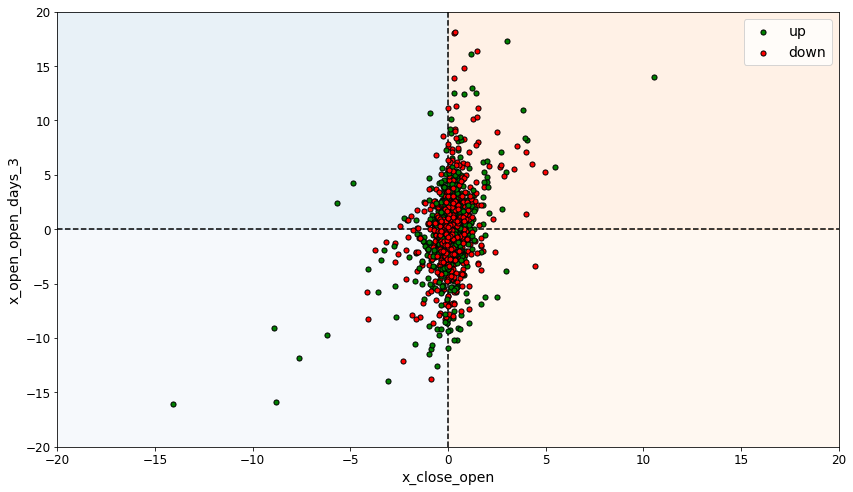

In [62]:
f, ax = plt.subplots(1,1)
x = 'x_close_open'
y = 'x_open_open_days_3'

for stock in stocks:
    df = df_arr[stock].copy()
    #print('Neg:',df_sel[df_sel[x]<0][y].replace(np.inf,np.nan).dropna().mean())
    #print('Pos:',df_sel[df_sel[x]>0][y].replace(np.inf,np.nan).dropna().mean())
    df[df['y_open_close_days_0_up']==1].plot(ax=ax,kind='scatter',x=x,y=y,s=26,color='g',edgecolor='black',zorder=3)
    df[df['y_open_close_days_0_up']==0].plot(ax=ax,kind='scatter',x=x,y=y,s=26,color='r',edgecolor='black',zorder=3)
    
x_width = 20
y_width = 20
ax.legend(['up','down'])
ax.set_title('')
pl.color_quantiles(ax,x_width,y_width)

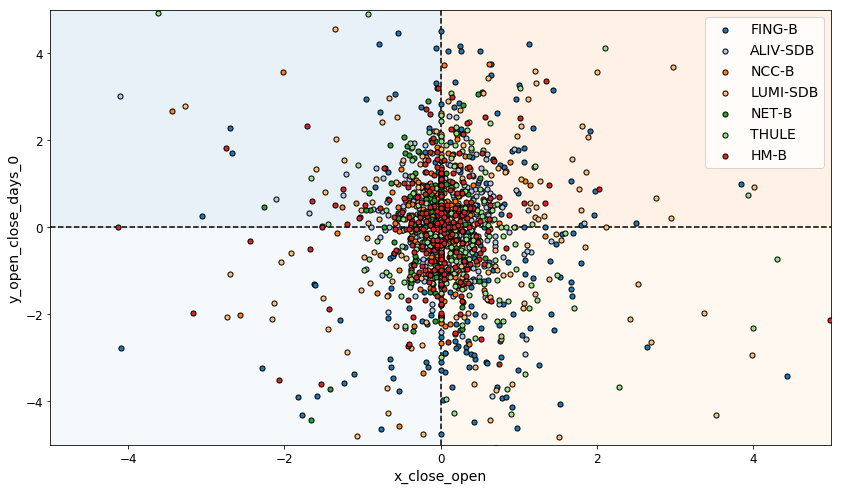

In [69]:
f, ax = plt.subplots(1,1)
x = 'x_close_open'
y = 'y_open_close_days_0'
tableau = style.get_tableau()

for nr,stock in enumerate(stocks):
    df = df_arr[stock].copy()
    #print('Neg:',df_sel[df_sel[x]<0][y].replace(np.inf,np.nan).dropna().mean())
    #print('Pos:',df_sel[df_sel[x]>0][y].replace(np.inf,np.nan).dropna().mean())
    df.plot(ax=ax,kind='scatter',x=x,y=y,s=26,edgecolor='black', color=tableau[nr],zorder=3)
    
x_width = 5
y_width = 5
ax.legend(stocks)
ax.set_title('')
pl.color_quantiles(ax,x_width,y_width)

# Predict

In [49]:
# What variables
x_var = [x for x in np.unique(df_arr[stocks[0]].columns) if 'x_' in x]
print(x_var)

['x_close_open', 'x_dayofmonth', 'x_low_high_day_1', 'x_low_high_day_10', 'x_low_high_day_2', 'x_low_high_day_3', 'x_low_high_day_4', 'x_low_high_day_5', 'x_low_high_day_6', 'x_low_high_day_7', 'x_low_high_day_8', 'x_low_high_day_9', 'x_low_high_days_1', 'x_low_high_days_10', 'x_low_high_days_2', 'x_low_high_days_3', 'x_low_high_days_4', 'x_low_high_days_5', 'x_low_high_days_6', 'x_low_high_days_7', 'x_low_high_days_8', 'x_low_high_days_9', 'x_month', 'x_open_open_day_1', 'x_open_open_day_10', 'x_open_open_day_1_up', 'x_open_open_day_1_up_streak', 'x_open_open_day_2', 'x_open_open_day_3', 'x_open_open_day_4', 'x_open_open_day_5', 'x_open_open_day_6', 'x_open_open_day_7', 'x_open_open_day_8', 'x_open_open_day_9', 'x_open_open_days_1', 'x_open_open_days_10', 'x_open_open_days_2', 'x_open_open_days_3', 'x_open_open_days_4', 'x_open_open_days_5', 'x_open_open_days_6', 'x_open_open_days_7', 'x_open_open_days_8', 'x_open_open_days_9', 'x_quarter', 'x_weekday', 'x_year']


Naive Score: 50.79
Score: 47.62
Days Tested: 63
Days Gained: -2


,y_open_close_days_0,pred_open_close_up
y_open_close_days_0_up,,
0.0,-1.927232,2
1.0,3.745194,2


Naive Score: 54.84
Score: 43.55
Days Tested: 62
Days Gained: -7


,y_open_close_days_0,pred_open_close_up
y_open_close_days_0_up,,
0.0,-0.760636,10
1.0,0.857421,9


Naive Score: 50.0
Score: 40.0
Days Tested: 60
Days Gained: -6


,y_open_close_days_0,pred_open_close_up
y_open_close_days_0_up,,
0.0,-0.661441,11
1.0,0.689485,6


Naive Score: 42.86
Score: 57.14
Days Tested: 35
Days Gained: 5


,y_open_close_days_0,pred_open_close_up
y_open_close_days_0_up,,
0.0,-1.255957,4
1.0,0.813834,5


Naive Score: 45.83
Score: 29.17
Days Tested: 24
Days Gained: -4


,y_open_close_days_0,pred_open_close_up
y_open_close_days_0_up,,
0.0,-0.790095,4
1.0,0.584319,3


Naive Score: 39.62
Score: 41.51
Days Tested: 53
Days Gained: 1


,y_open_close_days_0,pred_open_close_up
y_open_close_days_0_up,,
0.0,-0.491972,5
1.0,inf,2


Naive Score: 55.0
Score: 46.67
Days Tested: 60
Days Gained: -5


,y_open_close_days_0,pred_open_close_up
y_open_close_days_0_up,,
0.0,-0.270149,4
1.0,0.443826,9


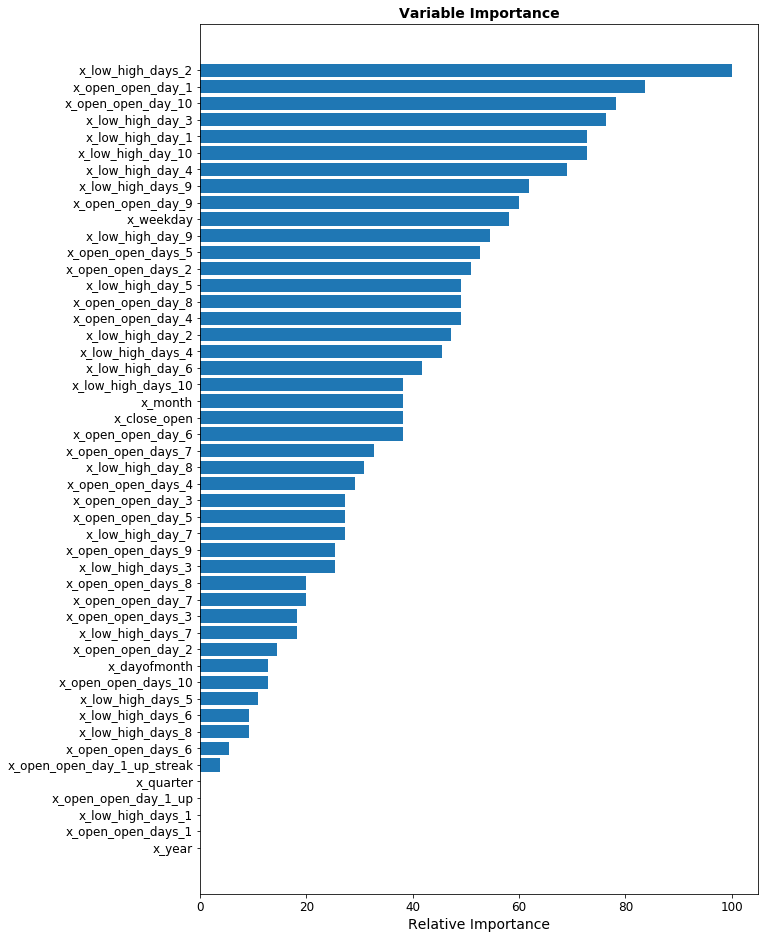

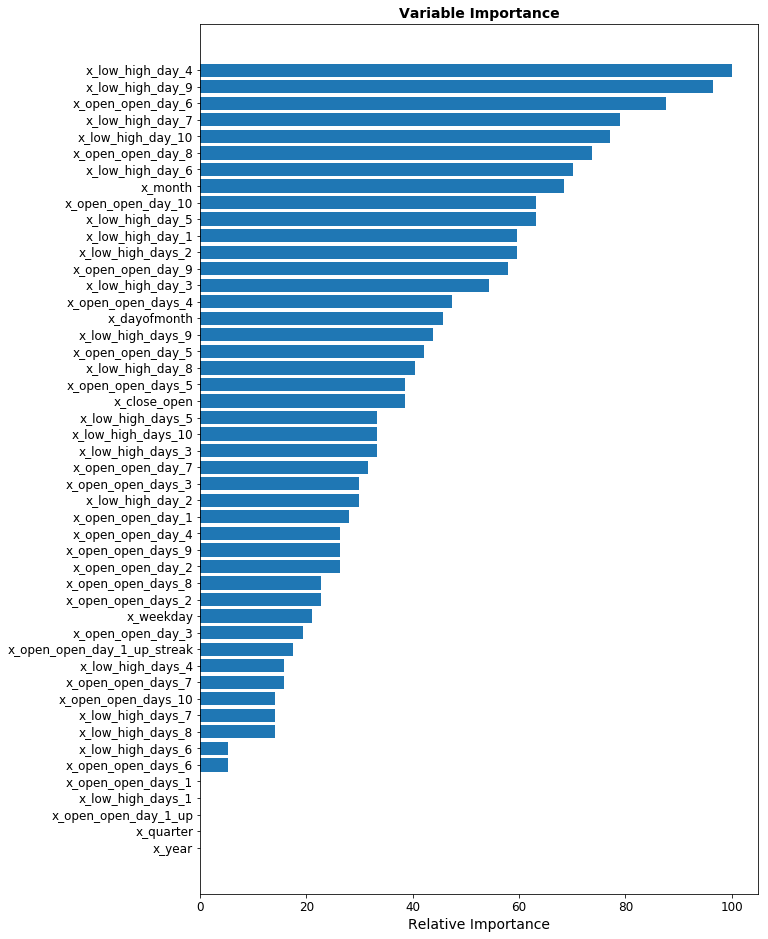

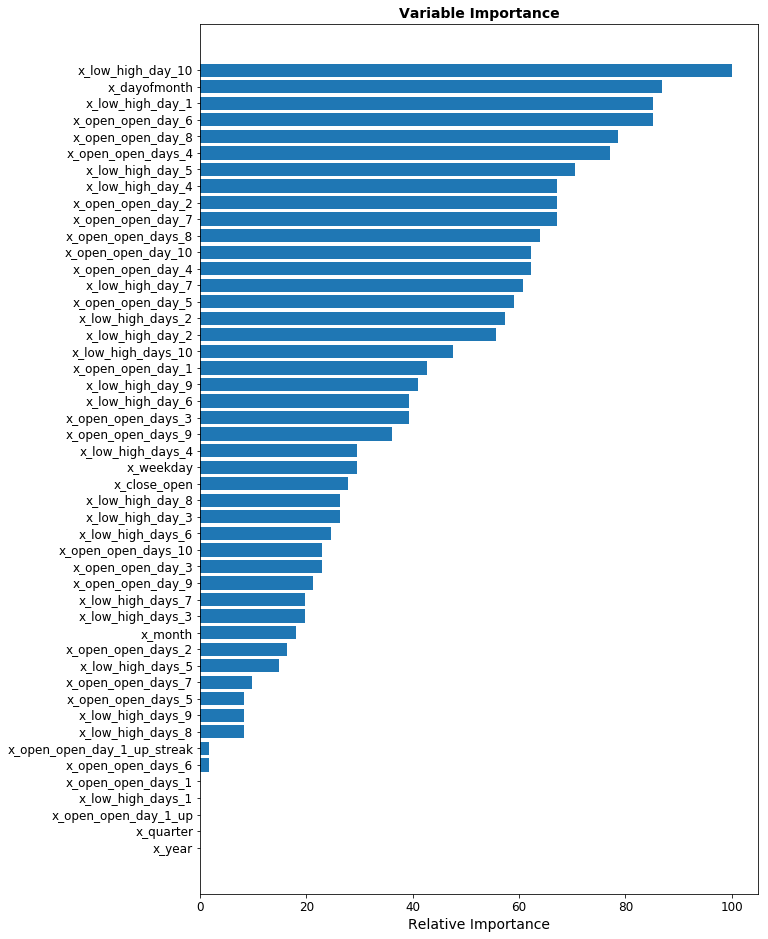

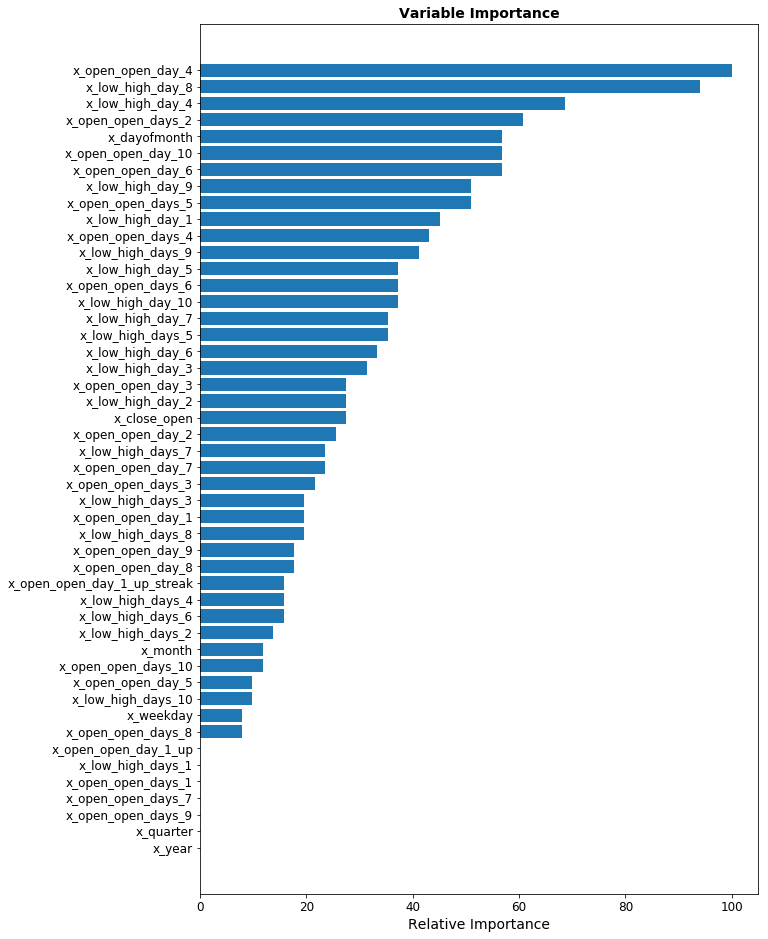

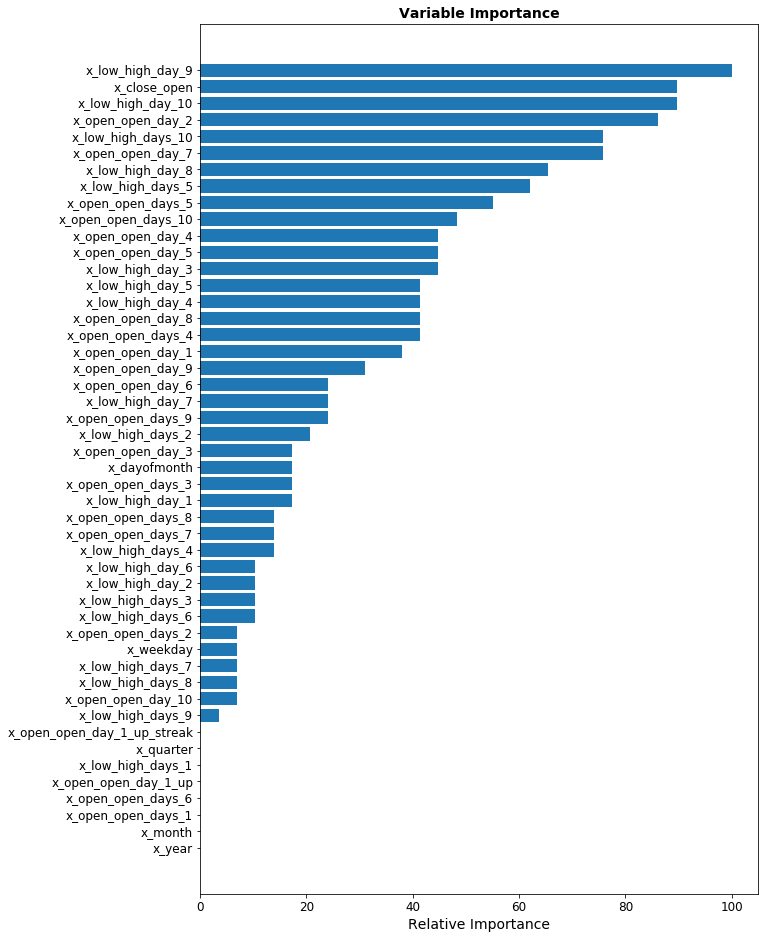

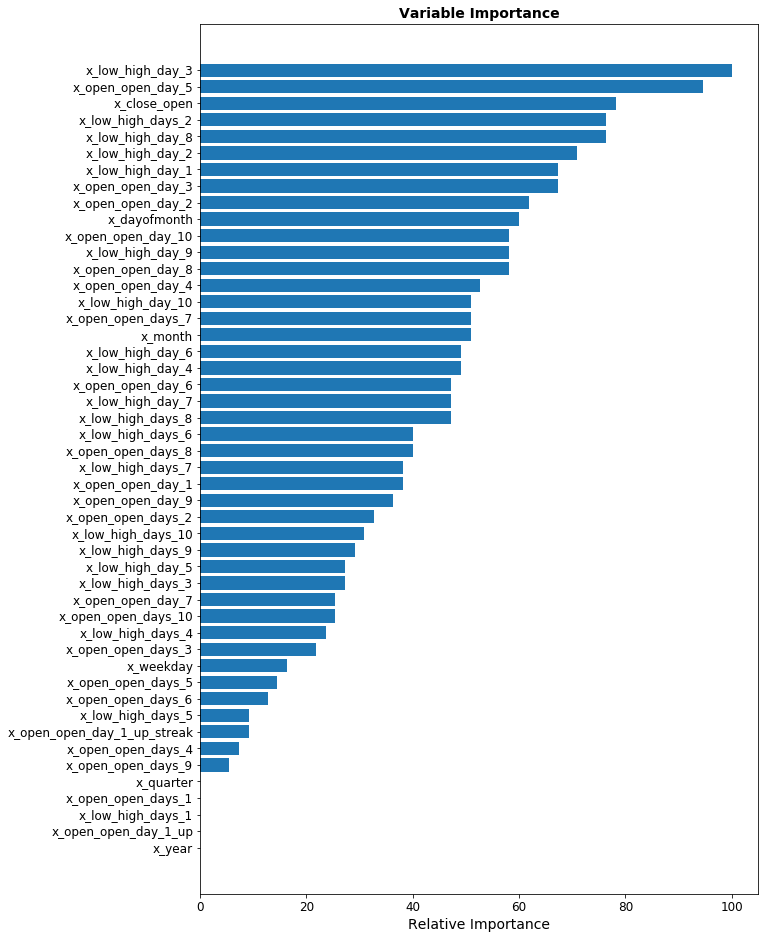

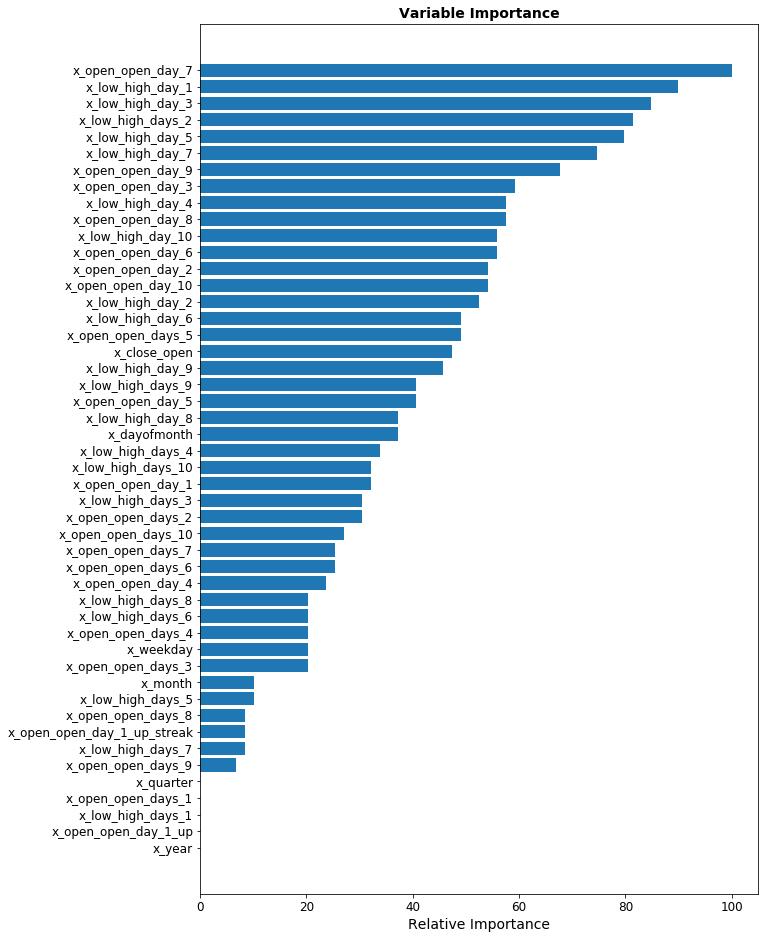

In [50]:
# Train, Test split
for stock in stocks:
    print(stock)
    df = df_arr[stock].copy()
    df = df.dropna()

    df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
    train, test = df[df['is_train']==True].copy(), df[df['is_train']==False].copy()
    x_train = train[x_var].values
    y_train = train['y_open_close_days_0_up'].values
    x_test = test[x_var].values
    y_test = test['y_open_close_days_0_up'].values

    x_combined = np.concatenate((x_train,x_test))
    y_combined = np.concatenate((y_train,y_test))


    # some info, naive score
    df_test = pd.DataFrame(y_test,columns=['up_down_days'])
    df_test_count = df_test.groupby('up_down_days')['up_down_days'].count()
    test_points = df_test_count.sum()
    naive_score = df_test_count.loc[1]/test_points
    
    # xgboost
    xgb = xgboost.XGBClassifier(max_depth=40,objective='binary:logistic')
    xgb.fit(x_train, y_train)
    ypred = xgb.predict_proba(x_test)
    score = xgb.score(x_test, y_test)

    days_gained = (score-naive_score)*test_points
    print('Naive Score:',round(naive_score*100,2))
    print('Score:',round(score*100,2))
    print('Days Tested:',test_points)
    print('Days Gained:',int(round(days_gained)))
    
    # Test only days we predict with certain certainty
    check_pred = test.join(pd.DataFrame(ypred,columns=['pred_open_close_down','pred_open_close_up'],index = test.index))
    agg = {'y_open_close_days_0':'mean',
           'pred_open_close_up':'count'}
    
    pred_with_confidence = check_pred[check_pred['pred_open_close_up']>0.8].groupby('y_open_close_days_0_up').agg(agg)
    display(pred_with_confidence)
    
    feature_importance(xgb,x_var)

In [51]:
def feature_importance(xgb,x_var,stock):
    # Plot feature importance
    f, ax = plt.subplots(1,1,figsize=(10,16))
    feature_importance = xgb.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)

    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(x_var)[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title(stock+' | Feature Importance')